In [1]:
import numpy as np
import sys
if "/opt/ros/kinetic/lib/python2.7/dist-packages" in sys.path:
    sys.path.remove("/opt/ros/kinetic/lib/python2.7/dist-packages")
import cv2
import struct
import math
import time

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import os 

from network.textnet import TextNet
from util.detection import TextDetector
from util.augmentation import BaseTransform
from util.config import config as cfg, update_config, print_config
from util.option import BaseOptions
from util.visualize import visualize_detection
from util.misc import to_device, mkdirs, rescale_result
from rotate_input import rotate_cv, rotate_back, rotate_back_change_h_w
from PIL import Image as Im
import tools.utils as utils
import tools.dataset as dataset
from models.moran import MORAN
from collections import OrderedDict

import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
print(sys.version)

3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609]


In [3]:
def read_commodity(path):
    _list = []
    for line in open(path, "r"):
        line = line.rstrip('\n')
        _list.append(line)
    print ("Finish reading list")
    return _list


In [4]:
alphabet = '0:1:2:3:4:5:6:7:8:9:a:b:c:d:e:f:g:h:i:j:k:l:m:n:o:p:q:r:s:t:u:v:w:x:y:z:$' 
cuda_use = torch.cuda.is_available()
means = (0.485, 0.456, 0.406)
stds = (0.229, 0.224, 0.225)
bbox_thres = 1500
color_map = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,255,255)] # 0 90 180 270 noise
commodity_list = read_commodity("./config/commodity_list.txt")

csv_file = "./val.csv"
data_list = pd.read_csv(csv_file)

Finish reading list


In [5]:
snake_network = TextNet(is_training=False, backbone='vgg')
if cuda_use:
    snake_network = snake_network.cuda()
    cuda_flag = True
    MORAN_network = MORAN(1, len(alphabet.split(':')), 256, 32, 100, BidirDecoder=True, CUDA=cuda_flag)
    MORAN_network = MORAN_network.cuda()
    MORAN_state_dict = torch.load(os.path.join("./model/", "demo.pth"))
else:
    MORAN_network = MORAN(1, len(alphabet.split(':')), 256, 32, 100, BidirDecoder=True, inputDataType='torch.FloatTensor', CUDA=cuda_flag)
    MORAN_state_dict = torch.load(os.path.join("./model/", "demo.pth"), map_location='cpu')
MORAN_state_dict_rename = OrderedDict()
for k, v in MORAN_state_dict.items():
    name = k.replace("module.", "") # remove `module.`
    MORAN_state_dict_rename[name] = v
    
MORAN_network.load_state_dict(MORAN_state_dict_rename)
converter = utils.strLabelConverterForAttention(alphabet, ':')
transformer = dataset.resizeNormalize((100, 32))

for p in MORAN_network.parameters():
    p.requires_grad = False
snake_network.load_model(os.path.join("./model/", "textsnake_vgg_0.pth"))   
MORAN_network.eval()
snake_network.eval()
detector = TextDetector(snake_network, tr_thresh=0.6, tcl_thresh=0.4)


/home/andyser/.local/lib/python3.5/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/andyser/code/text_detect_recognize/semantic_lables_sys/thesis/benchmark/models/asrn_res.py:234: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight, mode='fan_out', a=0)
/home/andyser/code/text_detect_recognize/semantic_lables_sys/thesis/benchmark/models/asrn_res.py:236: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.weight, 1)
/home/andyser/code/text_detect_recognize/semantic_lables_sys/thesis/benchmark/models/asrn_res.py:237: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


Loading from ./model/textsnake_vgg_0.pth


In [6]:
def region_predict(img):
    # # Preprocessing
    (rows, cols, channels) = img.shape
    image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    torch.cuda.synchronize()
    start = time.time()

    x = image.astype(np.float32)
    x = (x / 255 - means) / stds
    x = x.astype(np.float32)
    x = x[:, :, ::-1].copy()
    x = torch.from_numpy(x).permute(2, 0, 1)
    x = Variable(x.unsqueeze(0)) 
    if cuda_use:
        x = x.cuda()
    contours, output = detector.detect(x)

    torch.cuda.synchronize()
    end = time.time()
    print ("Text Detection Time : {}".format(end - start))

    image, contours = rescale_result(image, contours, rows, cols)
    img_viz = visualize_detection(image, contours)

    return img_viz, contours

## bbox = [xmin, xmax, ymin, ymax]
def recog_predict(bbox, contour, img, img_vis, mask, rot=0):
    # # Preprocessing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (rows, cols, channels) = img.shape
    
    if (bbox[3] - bbox[2]) * (bbox[1] - bbox[0]) < bbox_thres:
        return img, mask
    start = time.time()
    image = gray[bbox[2]:bbox[3], bbox[0]:bbox[1]]

    image = Im.fromarray(image) 
    image = transformer(image)

    if cuda_use:
        image = image.cuda()
    image = image.view(1, *image.size())
    image = Variable(image)
    text = torch.LongTensor(1 * 5)
    length = torch.IntTensor(1)
    text = Variable(text)
    length = Variable(length)

    max_iter = 20
    t, l = converter.encode('0'*max_iter)
    utils.loadData(text, t)
    utils.loadData(length, l)
    output = MORAN_network(image, length, text, text, test=True, debug=True)

    preds, preds_reverse = output[0]
    demo = output[1]

    _, preds = preds.max(1)
    _, preds_reverse = preds_reverse.max(1)

    sim_preds = converter.decode(preds.data, length.data)
    sim_preds = sim_preds.strip().split('$')[0]
    sim_preds_reverse = converter.decode(preds_reverse.data, length.data)
    sim_preds_reverse = sim_preds_reverse.strip().split('$')[0]

    # print('\nResult:\n' + 'Left to Right: ' + sim_preds + '\nRight to Left: ' + sim_preds_reverse + '\n\n')
    print ("Text Recognize Time : {}".format(time.time() - start))

    if sim_preds in commodity_list:
        cv2.rectangle(img, (bbox[0], bbox[2]),(bbox[1], bbox[3]), color_map[rot], 3)
        cv2.putText(img, sim_preds, (bbox[0], bbox[2]), 0, 1, (0, 255, 255),3)
        cv2.fillConvexPoly(mask, contour, commodity_list.index(sim_preds) + rot*len(commodity_list) + 1)
    else:
        correct, conf, _bool = conf_of_word(sim_preds)

        if _bool:
            cv2.putText(img, correct + "{:.2f}".format(conf), (bbox[0], bbox[2]), 0, 1, (0, 255, 255),3)
            cv2.rectangle(img, (bbox[0], bbox[2]),(bbox[1], bbox[3]), (255, 255, 255), 2)
            cv2.fillConvexPoly(mask, _cont, commodity_list.index(correct) + rot*len(commodity_list) + 1)
        else:
            cv2.putText(img, sim_preds, (bbox[0], bbox[2]), 0, 1, (0, 0, 0),3)
            cv2.rectangle(img, (bbox[0], bbox[2]),(bbox[1], bbox[3]), (0, 0, 0), 2)
        print (sim_preds, conf, correct, rot*90)

    return img, mask

In [7]:
def conf_of_word(target):
    total = np.zeros(len(commodity_list))

    for i in range(1, len(commodity_list)):
        
        err = 0  ## error 
        _len = len(commodity_list[i])
        arr = -10 * np.ones(_len)
        for j in range(len(target)):
            index = commodity_list[i].find(target[j])
            if index == -1:
                err += 1
            else:
                upper = arr[index+1] if index != _len - 1 else -10
                if arr[index] == -10 and upper == -10:
                    arr[index] = j
                else:
                    index = commodity_list[i].find(target[j], index + 1)
                    while index != -1:
                        lower = arr[index-1] if index != 0 else -10
                        upper = arr[index+1] if index != _len - 1 else -10
                        if (arr[index] - lower) == 1 or (upper - arr[index]) == 1:
                            index = commodity_list[i].find(target[j], index + 1)
                        else:
                            arr[index] = j
                            break

        score = 0   # score for word 
        for j in range(_len - 1):
            if arr[j+1] - arr[j] == 1:
                score += 1
        total[i] = float(score) / (_len + err - 1)

    return commodity_list[np.argmax(total)], np.max(total), np.max(total) > 0.4

In [8]:
def adj(_img, _level = 8):
    (colomn, row) = _img.shape
    _count = 0
    _pixel_pair = []
    label = np.zeros((colomn,row),dtype = np.uint8)
    for i in range(colomn):
        for j in range(row):
            if (_img[i,j] == 1 and label[i,j] == 0):
                _pixel_pair.append([i,j])
                _count += 1
            while len(_pixel_pair) != 0:
                pair = _pixel_pair.pop()
                a = pair[1] + 1
                b = pair[1] - 1
                c = pair[0] + 1
                d = pair[0] - 1
                if a == 640 : a -= 1
                if b == -1  : b += 1
                if c == 480 : c -= 1
                if d == -1  : d += 1

                if _img[pair[0],a] == 1 and label[pair[0],a] == 0:
                    _pixel_pair.append([pair[0],a])
                if _img[pair[0],b] == 1 and label[pair[0],b] == 0:
                    _pixel_pair.append([pair[0],b])
                if _img[c,pair[1]] == 1 and label[c,pair[1]] == 0:
                    _pixel_pair.append([c,pair[1]])
                if _img[d,pair[1]] == 1 and label[d,pair[1]] == 0:
                    _pixel_pair.append([d,pair[1]])
                if _level == 8:
                    if _img[c,a] == 1 and label[c,a] == 0:
                        _pixel_pair.append([c,a])
                    if _img[d,a] == 1 and label[d,a] == 0:
                        _pixel_pair.append([d,a])
                    if _img[d,b] == 1 and label[d,b] == 0:
                        _pixel_pair.append([d,b])
                    if _img[c,b] == 1 and label[c,b] == 0:
                        _pixel_pair.append([c,b])
                label[pair[0],pair[1]] = _count

    print("Num of classes for connected components : ", _count)
    return label

Text Detection Time : 0.07269024848937988
Text Recognize Time : 0.03628349304199219
koonex 0.5 kloone 0
Text Detection Time : 0.06598639488220215
Text Detection Time : 0.07681488990783691
Text Recognize Time : 0.03731226921081543
moved 0.0 crayons 180
Text Detection Time : 0.06676745414733887
Num of classes for connected components :  1
Num of classes for connected components :  1


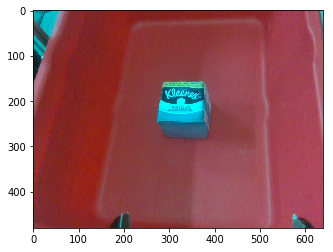

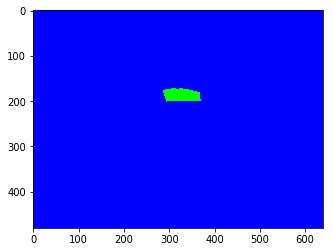

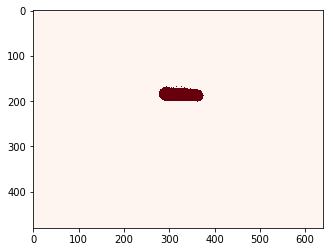

0.7443946188340808 1992.0 2676.0
[0 2]
[0. 2.]
153


In [16]:
TP = np.zeros((41), dtype = np.float128)
FP = np.zeros((41), dtype = np.float128)
FN = np.zeros((41), dtype = np.float128)
_sum_origin = 0
_sum_detection = 0

theta_sum = 0.
theta_count = 0
iou_sum = 0.
_total_bn_up = 0
for idx in range(len(data_list)):
    img_name   = data_list.iloc[idx, 0]
    img        = cv2.imread(img_name,cv2.IMREAD_UNCHANGED)
    label_name = data_list.iloc[idx, 1]
    label      = cv2.imread(label_name, cv2.IMREAD_GRAYSCALE)
    if "single" not in img_name or "color_26.jpg" not in img_name:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ### Detection & Recognition
    label[label == 246] = 0
    
    mask = np.zeros([img.shape[0], img.shape[1]], dtype = np.uint8)
    img_list_0_90_180_270 = rotate_cv(img)
    
    for i in range(4):

        predict_img, contours = region_predict(img_list_0_90_180_270[i])
        img_bbox = img_list_0_90_180_270[i].copy()
        img_input_vis = img_bbox.copy()
        img_input_rec = img_bbox.copy()
        (rows, cols, channels) = img_bbox.shape
        mask_vis = np.zeros([rows, cols], dtype = np.uint8)
        for _cont in contours:
            
#             cv2.fillConvexPoly(mask_vis, _cont, 1)
            
            cv2.drawContours(predict_img, [_cont], -1, color_map[i], 3)
            cv2.rectangle(img_bbox, (min(_cont[:,0]), min(_cont[:,1])),(max(_cont[:,0]), max(_cont[:,1])), color_map[i], 3)
            bbox = [min(_cont[:,0]),max(_cont[:,0]),min(_cont[:,1]),max(_cont[:,1])]
            img_input_vis, mask_vis = recog_predict(bbox, _cont, img_input_rec,img_input_vis, mask_vis, rot = i)
            

        if i == 0:
            pass
        elif i == 1:
            mask_vis = rotate_back_change_h_w(mask_vis, angle = -90)
        elif i == 2:
            mask_vis = rotate_back(mask_vis, angle = -180)
        else:
            mask_vis = rotate_back_change_h_w(mask_vis, angle = -270)
        mask[mask_vis != 0] = mask_vis[mask_vis != 0]
    
    
    ###########
    #### For detection evaluation
    
#     mask_vis = label*mask_vis
#     mask_vis[mask_vis != 0] = 1
#     label[label != 0] = 1
#     _label_1 = adj(label)
#     _label_2 = adj(mask_vis)
#     _sum_origin += len(np.unique(_label_1)) - 1
#     _sum_detection += len(np.unique(_label_2)) - 1 
    
#     print (len(np.unique(_label_1)))
#     print (len(np.unique(_label_2)))
    
    #### Confusion Matrix
    
    
#     plt.figure()
#     plt.imshow(img)
#     plt.show()
    
#     plt.figure()
#     plt.imshow(_label_1,  cmap = "gray", vmin = 0, vmax = 10)
#     plt.show()

#     plt.figure()
#     plt.imshow(_label_2, cmap = "gray", vmin = 0, vmax = 1)
#     plt.show()
    
    label = label/6
    for j in range(11,41):
        c = j
        while(c>10):
            c-=10
        label[label == j] = c
        mask[mask == j] = c
        
    #### Brandbase evaluation
    obj_list = np.unique(label)
    for pix in obj_list:
        if pix != 0:
            mask_source = np.zeros([img.shape[0], img.shape[1]], dtype = np.uint8)
            mask_target = np.zeros([img.shape[0], img.shape[1]], dtype = np.uint8)
            
            mask_source[label == pix] = 1
            mask_target[mask == pix] = 1
            
            label_sor = adj(mask_source)
            label_tar = adj(mask_target)
            pix_sor = np.unique(label_sor)
            pix_tar = np.unique(label_tar)
            for p1 in pix_sor:
                if p1 != 0:
                    _total_bn_up += 1
                    temp_sor = np.zeros([img.shape[0], img.shape[1]], dtype = np.uint8)
                    temp_sor[label_sor == p1] = 1
                    for p2 in pix_tar: 
                        if p2 != 0:
                            temp_tar = np.zeros([img.shape[0], img.shape[1]], dtype = np.uint8)
                            temp_tar[label_tar == p2] = 1
                            
                            kernel = np.ones((3,3),np.uint8)  
                            temp_tar = cv2.erode(temp_tar,kernel,iterations = 1)
                            
                            _and_pix = float(sum(sum(np.logical_and(temp_sor, temp_tar))))
                            _or_pix = float(sum(sum(np.logical_or(temp_sor, temp_tar))))
                            iou_rate = _and_pix/_or_pix
                            if iou_rate >= 0.5:
                                contours1, _ = cv2.findContours(temp_sor, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                                contours2, _ = cv2.findContours(temp_tar, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                                
                                rect1 = cv2.minAreaRect(contours1[0])
                                box1 = cv2.boxPoints(rect1)
                                box1 = np.int0(box1)
                                
                                rect2 = cv2.minAreaRect(contours2[0])
                                box2 = cv2.boxPoints(rect2)
                                box2 = np.int0(box2)  
                                
                                theta1 = np.arctan2(box1[0][1]-box1[1][1], box1[0][0]-box1[1][0])/3.1415926*180
                                theta2 = np.arctan2(box2[0][1]-box2[1][1], box2[0][0]-box2[1][0])/3.1415926*180
                                
                                dis = np.absolute(theta2-theta1)
                                if dis > 45:
                                    dis = 90 - dis 
                                
                                theta_count += 1
                                theta_sum += dis
                                iou_sum += iou_rate
#                                 print (dis)
                                
                                plt.figure()
                                plt.imshow(img)
                                plt.show()

                                plt.figure()
                                plt.imshow(temp_sor,  cmap = "brg", vmin = 0, vmax = 1)
                                plt.show()

                                plt.figure()
                                plt.imshow(temp_tar, cmap = "Reds", vmin = 0, vmax = 1)
                                plt.show()                                
                                print (iou_rate,_and_pix,_or_pix)
                            
                    
        
    #####
    
    print (np.unique(mask))
    print (np.unique(label))
    target = mask.reshape(480 * 640)
    pred = label.reshape(480 * 640)

    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,41,1))
    con_matrix[0][0] = 0
    for i in range(0, 41):
        for j in range(0, 41):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    print(idx)
    

In [ ]:
print (_total_bn_up)
print (theta_count)
print (theta_sum / theta_count)
print (iou_sum / theta_count)

In [49]:
print (_sum_origin, _sum_detection)
FN[0] = 0
FP[0] = 0
print (TP)
print (FN)
print (FP)

0 0
[    0.  3220.  2527. 23065. 13031. 10852.  1988.  7560. 14884. 11347.
 16046.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.]
[    0.     0.  2470. 12148.  5522.  4875.  4131.  6636. 16505.  4966.
  7403.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.]
[    0.  1374. 10070. 22898.  2109.   373.    65.  2903.  3640.  9998.
   853.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.]


In [50]:
recall = TP / (TP + FN)
precision = TP / (TP + FP)
ious = TP / (TP + FN + FP)
fscore = 2*TP / (2*TP + FN + FP)

/home/andyser/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/andyser/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/andyser/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/andyser/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [52]:
print (ious)
print (fscore)
print (sum(ious[1:11]/10))
print (sum(fscore[1:11]/10))
2*sum(TP) / (2*sum(TP) + sum(FN) + sum(FP))

[       nan 0.70091424 0.16771753 0.3969128  0.63067467 0.67403727
 0.32147477 0.44213112 0.42490508 0.43126449 0.66027487        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan]
[       nan 0.82416176 0.28725702 0.56827141 0.77351379 0.80528347
 0.4865394  0.61316355 0.59639773 0.60263423 0.79538019        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan]
0.48503068403625244052
0.63526025562783965713


0.63735787962034154625

In [131]:
### IOU
0.42548957096516391334
0.5284407007142797736          0.5421415715311996553
0.5044586460943159716          0.5388207442850785732
0.38584792222682856477         0.43220951477705407327
0.46073640775482894497         0.42075081174636323325
0.48503068403625244052          0.49718318712174729647

0.4971831871217473

In [53]:
### F-score
0.59014847078778318024        0.6139501681337725087
0.6852427911485629876
0.66380536213827919965         0.66187100446803369657
0.53617502895716315014        0.5598313305769117412
0.6238636460835660344        0.53806262726474883533
0.63526025562783965713         0.60057070070623645773

SyntaxError: invalid syntax (<ipython-input-53-3f96fb624380>, line 2)

In [2]:
GPU Comparison
Inference Time
Text Avg Detection Time : 0.075
Text Avg Recognize Time : 0.034
FCN: 0.318

RAM Needed
SnakeText : 613 Mb
MORAN : 723 Mb
    
FCN : 1806 Mb

SyntaxError: invalid syntax (<ipython-input-2-6885a956a83b>, line 1)

In [ ]:
### Text detection result
37/50
108/145
115/159


26 / 50
3.1094410898469844
0.6620932068194665

114 / 145
2.7959681340597156
0.6834069119013017

116 / 159
3.33064518315082
0.6862443603729517

16 / 31
4.157111493864659
0.6179058317411024

20 / 32
4.653125144053842
0.630576208541251

42 / 59
3.6050439487907227
0.6773317515173449